## Testing Pretrained ResNet101

1. Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


2. Change Runtime to "GPU"

3. Test a sample using the pre-trained ResNet101

In [ ]:
# https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/

import torch, torchvision
from PIL import Image
import tensorflow as tf

# load model
resnet = torchvision.models.resnet101(pretrained=True)

# set network to evaluation mode
resnet.eval()

transform = torchvision.transforms.Compose([          
 torchvision.transforms.Resize(256),              
 torchvision.transforms.ToTensor(),                     
 torchvision.transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                            
 std=[0.229, 0.224, 0.225]                             
 )])


img = Image.open("/content/gdrive/MyDrive/samoyed.jpg") # You can download an image of a dog from Internet or capture an image by yourself.
img_t = transform(img)
print(img_t.shape)

## ============= DATA AUGMENTATION ======================

resnet_resol = 224
crop_size = [3, 224, 224]

## Cropping into 5 different parts
"""
OFFSET_TEMPLATE = [ DIMENSION_OFFSET, HEIGHT_OFFSET, WIDTH_OFFSET ]

Upper left offset = [0, 0, 0]

Lower left offset = [0, HEIGHT_OF_IMAGE - 224, 0] 
                  = [0, 256 - 224, 0] 
                  = [0, 32, 0]

Center offset = [0, (HEIGHT_OF_IMAGE - 224)/2 , (WIDTH_OF_IMAGE - 224)/2 ]
              = [0, (256 - 224)/2, (442 - 224)/2 ]
              = [0, 16, 110]

Lower right offset = [0,(HEIGHT_OF_IMAGE - 224), (WIDTH_OF_IMAGE - 224)]
                   = [0, 256 - 224, 442 - 224]
                   = [0, 32, 218]

Upper right offset = [0, 0, WIDTH_OF_IMAGE - 224]
                   = [0, 0, 442 - 224]
                   = [0, 0, 218]
""" 

upper_left_crop = tf.slice(img_t, [0, 0, 0], crop_size)
lower_left_crop = tf.slice(img_t, [0,32,0], crop_size)
center_crop = tf.slice(img_t, [0,16,110], crop_size)
lower_right_crop = tf.slice(img_t, [0, 32, 218], crop_size)
upper_right_crop = tf.slice(img_t, [0, 0, 218], crop_size)

# Average over 5 crops
img_t = tf.math.divide(tf.math.add_n([upper_left_crop, lower_left_crop, center_crop, lower_right_crop, upper_right_crop]), 5).numpy()

## ======================================================

batch_t = torch.unsqueeze(torch.Tensor(img_t), 0)

# perform inference
out = resnet(batch_t)

# print top-5 classes predicted by model
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
for idx in indices[0][:5]:
  print('Label:', idx, '. Confidence Score:', percentage[idx].item(), '%')


torch.Size([3, 256, 442])
Label: tensor(258) . Confidence Score: 94.83811950683594 %
Label: tensor(270) . Confidence Score: 1.479285717010498 %
Label: tensor(248) . Confidence Score: 0.884604811668396 %
Label: tensor(279) . Confidence Score: 0.6333107352256775 %
Label: tensor(257) . Confidence Score: 0.38571444153785706 %


4. Refer to https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b, to check if the predicted classes are meaningful.


---


### The pre-trained RESNET101 model predicted the image as Samoyed (Image Class 258). This result is accurate as I indeed downloaded an image of a Samoyed dog.


---



5. Task

    Modify the code above, to peform data augmentation for the testing sample (averaging the scores of 5 crops: center crop, upper left crop, lower left crop, lower right crop, upper right crop).

    Pls briefly discuss the advantages and disadvantages of using testing data augmentation.

###### Hint: use tensor slicing five times


---



## Data Augmentation in Testing:

### Advantages:
- Able to increase accuracy on inference (prediction) because we take an average of 5 aggregated inferences. When we take average the 5 inferences, we also average their errors. This means even if a single vector/inference happens to have a high error, it will be averaged out with other inferences and the final prediction will not be affected too much by this high error. Ultimately, data augmentation gives more confidence and accuracy in guessing the correct class.

- Test-time data augmentation can be applied directly to any trained model (post-training). Unlike train-time data augmentation, we do not need to make any changes to the model when doing test-time data augmentation.

- The trained model might be more sensitive & accurate when infering specific orientations or sizes of features. By doing data augmentation, an original image that may not be of that orientation or size can be transformed into such optimal orientation or size, giving higher overall accuracy in the end.

### Disadvantages:
- Test-time data augmentation is slower than single sample testing due to more processing requirements (summing, averaging, etc.). This might cause test-time data augmentation to be infeasible in inferring classes in real-time.

- In some rare instances, images might only have content at a specific part of the image. For example, let's say there is an image with a cat lying on the ground but the cat is placed at the top right of the image (see image below). The five crop method above might give lower accuracy because the cat will only be detected on the top right crop and not anywhere else.

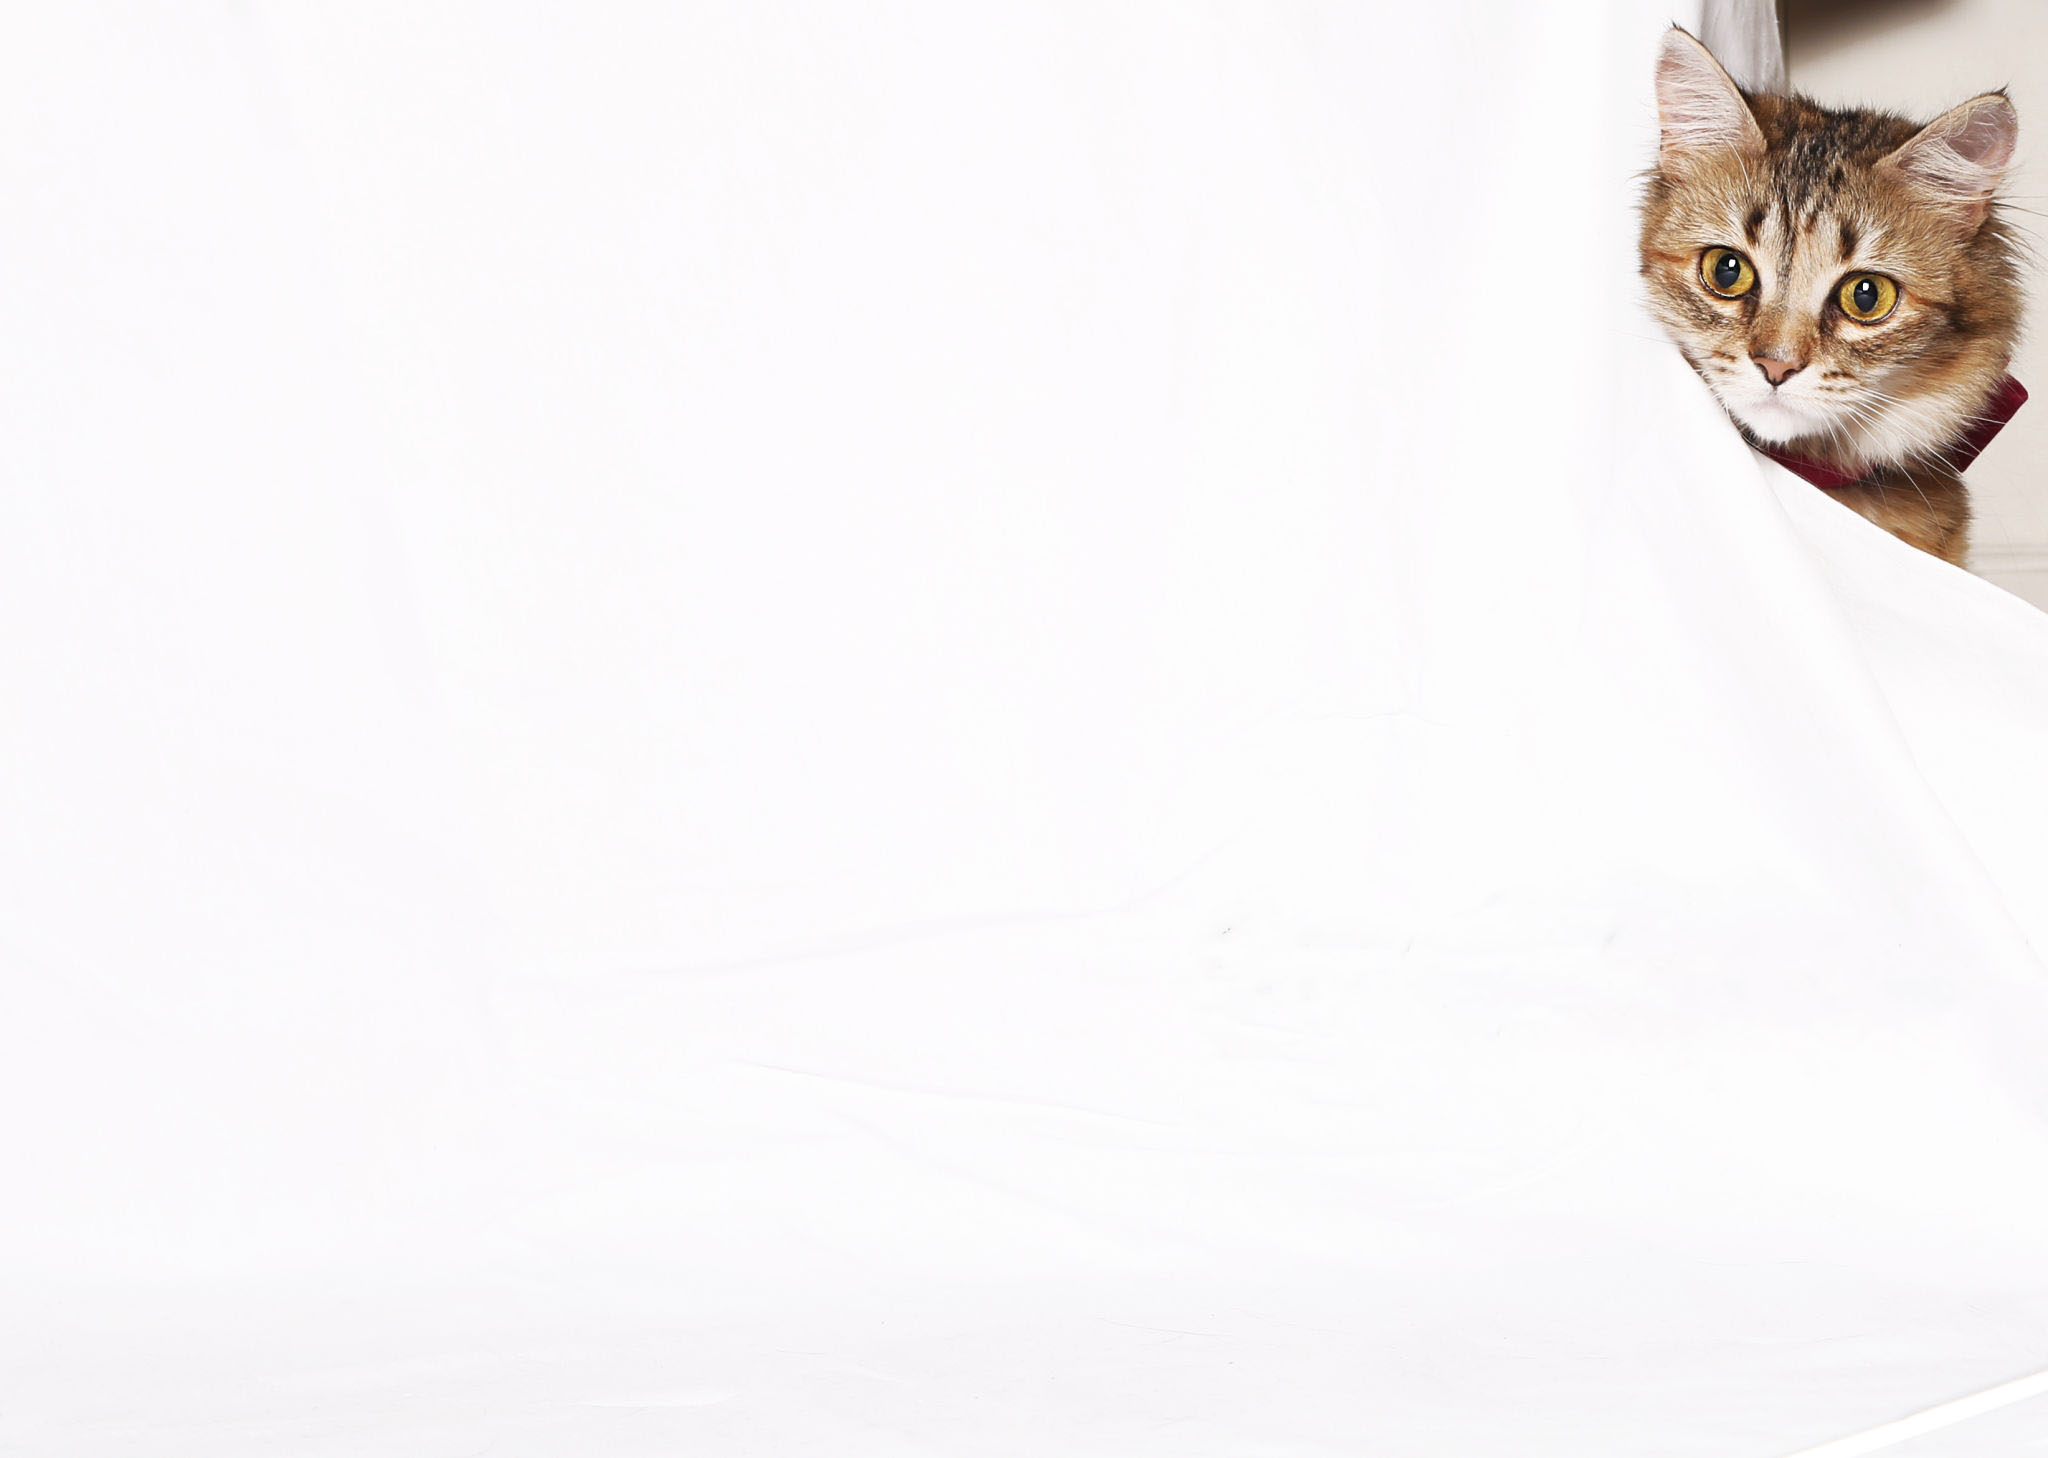